In [161]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# standard symbolic algebra module
#import sympy as sm
#sm.init_printing()

# module to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn
from torch.utils import data

# split data into a training set and a test set
from sklearn.model_selection import train_test_split
# linearly transform a feature to zero mean and unit variance
from sklearn.preprocessing import StandardScaler

# to reload modules
import importlib

%matplotlib inline

import matplotlib as mp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
#seed = 128
#rnd  = np.random.RandomState(seed)

from sklearn.model_selection import train_test_split
import copy

In [162]:
df = pd.read_csv('Data.csv')
df.head()

,Unnamed: 0,rawRecoDatapT,rawRecoDataeta,rawRecoDataphi,rawRecoDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,genDatapT,genDataeta,genDataphi,genDatam,tau
0,0,29.0586,3.511970,1.503010,5.69919,40.3892,3.41479,1.47023,12.53740,45.4608,3.379820,1.470130,13.24440,0.536525
1,1,47.9465,0.776638,-1.251970,6.72517,40.3892,3.41479,1.47023,12.53740,56.2643,0.811412,-1.324120,10.55060,0.130536
2,2,29.5200,-1.084730,1.834230,4.06446,29.3586,-1.17862,1.84039,9.95503,34.6377,-1.131020,1.801820,7.65844,0.500162
3,3,23.2719,-2.822960,0.216718,3.50878,20.9593,2.13374,-2.86886,9.55921,27.4120,-2.842550,0.345529,5.18675,0.490624
4,4,30.4644,2.985000,1.306930,4.11101,35.2909,2.96499,1.36464,10.69580,30.3263,3.040300,1.341270,5.74890,0.417064


In [163]:
df = df.iloc[:,5:]
df.head()

,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,genDatapT,genDataeta,genDataphi,genDatam,tau
0,40.3892,3.41479,1.47023,12.53740,45.4608,3.379820,1.470130,13.24440,0.536525
1,40.3892,3.41479,1.47023,12.53740,56.2643,0.811412,-1.324120,10.55060,0.130536
2,29.3586,-1.17862,1.84039,9.95503,34.6377,-1.131020,1.801820,7.65844,0.500162
3,20.9593,2.13374,-2.86886,9.55921,27.4120,-2.842550,0.345529,5.18675,0.490624
4,35.2909,2.96499,1.36464,10.69580,30.3263,3.040300,1.341270,5.74890,0.417064


In [164]:
levels = ['genData', 'RecoData']
kinematics=['pT','eta','phi','m']
targets = kinematics#for reco level, but same names
Networks = ['RecoNN', 'genNN']

target = df['RecoDatapT'].to_numpy()
data =  df.drop('RecoDatapT', axis=1).to_numpy()
data

array([[ 3.41479   ,  1.47023   , 12.5374    , ...,  1.47013   ,
        13.2444    ,  0.53652539],
       [ 3.41479   ,  1.47023   , 12.5374    , ..., -1.32412   ,
        10.5506    ,  0.13053623],
       [-1.17862   ,  1.84039   ,  9.95503   , ...,  1.80182   ,
         7.65844   ,  0.50016227],
       ...,
       [-1.49005   , -1.42238   , 11.155     , ...,  1.85921   ,
         8.8265    ,  0.11958587],
       [-0.654844  , -1.26413   ,  3.893     , ..., -1.21499   ,
         4.87261   ,  0.5541255 ],
       [-1.10686   ,  1.3181    ,  6.0953    , ...,  1.33004   ,
         3.94825   ,  0.05202467]])

In [165]:
target

array([40.3892, 40.3892, 29.3586, ..., 27.0034, 23.8815, 33.2208])

In [166]:
# train_targets = train_targets.reshape(-1,1)
# test_targets = test_targets.reshape(-1,1)

print('target shape', train_targets.shape)
print('input data shape', data.shape)

target shape (80000, 1)
input data shape (100000, 8)


In [167]:
ntargets = 1
train_data, test_data, train_targets, test_targets = train_test_split(data, target, test_size=0.2)


In [168]:
train_targets = train_targets.reshape(-1,1)
test_targets = test_targets.reshape(-1,1)

sets= [train_data, test_data, train_targets, test_targets]
set_names = ['train_data', 'test_data', 'train_targets', 'test_targets']
# vnames = [name for name in globals() if globals()[name] is variable]

def variable_string(variable):
    return [k for k, v in locals().items() if v == variable][0]

for var_name, var in zip(set_names, sets):
    print(var_name 
          + ' shape = ', var.shape, '\n')

train_data shape =  (80000, 8) 

test_data shape =  (20000, 8) 

train_targets shape =  (80000, 1) 

test_targets shape =  (20000, 1) 



In [169]:
# sc = StandardScaler()#this is always recommended for logistic regression
# train_data= sc.fit_transform(train_data)
# test_data = sc.transform(test_data)
# train_data.mean(), (train_data.std())**2#check to make sure mean=0, std=1

In [170]:
class CustomDataset:
    """This takes the index for the data and target and gives dictionary of tensors of data and targets.
    For example we could do train_dataset = CustomDataset(train_data, train_targets); test_dataset = CustomDataset(test_data, test_targets)
 where train and test_dataset are np arrays that are reshaped to (-1,1).
 Then train_dataset[0] gives a dictionary of samples "X" and targets"""
    def __init__(self, data, targets):
        self.data = data
        self.targets=targets
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        
        current_sample = self.data[idx, :]
        current_target = self.targets[idx]
        return {"x": torch.tensor(current_sample, dtype = torch.float),
               "y": torch.tensor(current_target, dtype= torch.float),
               }#this already makes the targets made of one tensor (of one value) each
    
train_dataset = CustomDataset(train_data, train_targets)
test_dataset = CustomDataset(test_data, test_targets)
print(train_dataset[0], train_dataset)

{'x': tensor([ 3.9172e+00, -1.6980e+00,  5.8360e+00,  3.2731e+01, -3.0877e-02,
         1.7757e+00,  6.8790e+00,  4.9855e-01]), 'y': tensor([30.9906])} <__main__.CustomDataset object at 0x7fdb7143bb90>


In [171]:
batch_size=5
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=2, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, num_workers=2)

In [172]:
# from mymodels import RegressionModel
class RegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.ReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 
        
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)
            
    
    def forward(self, x):
        return self.model(x)

In [173]:
# n_examples, n_inputs = train_data.shape
# n_outputs, n_hidden = 1, 16
print('train_data.shape = ',train_data.shape)

train_data.shape =  (80000, 8)


In [174]:
model =  RegressionModel(nfeatures=train_data.shape[1], 
               ntargets=1,
               nlayers=8, 
               hidden_size=16, 
               dropout=0.3)
print(model)

RegressionModel(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=16, bias=True)
    (13): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.3, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=16, out_features=16, bias=True)
    (17): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_

In [214]:
# %writefile training/RegressionEngine.py
class RegressionEngine:
    """loss, training and evaluation"""
    def __init__(self, model, optimizer):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        
    #the loss function returns the loss function. It is a static method so it doesn't need self
    @staticmethod
    def quadratic_loss(targets, outputs):
         return nn.MSELoss()(outputs, targets)

    @staticmethod
    def average_quadratic_loss(targets, outputs):
    # f and t must be of the same shape
        return  torch.mean((outputs - targets)**2)
    
    @staticmethod
    def average_absolute_error(targets, outputs):
    # f and t must be of the same shape
        return  torch.mean(abs(outputs - targets))
    
    
    @staticmethod
    def average_cross_entropy_loss(targets, outputs):
        # f and t must be of the same shape
        loss = torch.where(targets > 0.5, torch.log(outputs), torch.log(1 - outputs))
        return -torch.mean(loss)
    
    @staticmethod
    def average_quantile_loss(targets, outputs):
        # f and t must be of the same shape
        tau = torch.rand(outputs.shape)
        return torch.mean(torch.where(targets >= outputs, 
                                      tau * abs(targets - outputs), 
                                      (1 - tau)*abs(outputs - targets)))

    def train(self, data_loader):
        """the training function: takes the training dataloader"""
        self.model.train()
        final_loss = 0
        for data in data_loader:
            self.optimizer.zero_grad()#only optimize weights for the current batch, otherwise it's meaningless!
            inputs = data["x"]
            targets = data["y"]
            outputs = self.model(inputs)
            loss = self.average_quantile_loss(targets, outputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
            return final_loss / len(data_loader)

    
    def evaluate(self, data_loader):
        """the training function: takes the training dataloader"""
        self.model.eval()
        final_loss = 0
        for data in data_loader:
            inputs = data["x"]#.to(self.device)
            targets = data["y"]#.to(self.device)
            outputs = self.model(inputs)
            loss = self.average_quantile_loss(targets, outputs)
            final_loss += loss.item()
            return outputs.flatten()
            #return final_loss / len(data_loader)

In [215]:
def train(optimizer, engine, early_stopping_iter, epochs):
    train_losses, test_losses = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    eng = RegressionEngine(model=model, optimizer = optimizer)
    best_loss = np.inf
    early_stopping_iter = 10
    early_stopping_counter = 0
    # EPOCHS=22
    EPOCHS=epochs
    for epoch in range(EPOCHS):
        train_loss = eng.train(train_loader)
        test_loss = eng.train(test_loader)
        print("Epoch : %-10g, Training Loss: %-10g, Test Loss: %-10g" % (epoch, train_loss, test_loss))
        #print(f"{epoch}, {train_loss}, {test_loss}")
        if test_loss < best_loss:
            best_loss = test_loss

        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_iter:
            #if we are not improving for 10 iterations then break the loop
            #we could save best model here
            break
    
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
    train_losses=np.array(train_losses); test_losses=np.array(test_losses)
    
    fig = plt.figure(figsize=(5, 5))
    
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_title("Average loss")
    
    epoch_list = np.arange(1, train_losses.shape[0]+1)
    ax.plot(epoch_list, train_losses, label = 'Train')
    ax.plot(epoch_list, test_losses, label='Test')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    return train_losses, test_losses

    

Epoch : 0         , Training Loss: 0.000917102, Test Loss: 0.00336703
Epoch : 1         , Training Loss: 0.000687194, Test Loss: 0.002986  
Epoch : 2         , Training Loss: 0.000793731, Test Loss: 0.00280183
Epoch : 3         , Training Loss: 0.00077007, Test Loss: 0.0040017 
Epoch : 4         , Training Loss: 0.00120342, Test Loss: 0.00182377
Epoch : 5         , Training Loss: 0.00110623, Test Loss: 0.00355007
Epoch : 6         , Training Loss: 0.000562496, Test Loss: 0.00248925
Epoch : 7         , Training Loss: 0.000315926, Test Loss: 0.00356588
Epoch : 8         , Training Loss: 0.00034049, Test Loss: 0.00369664
Epoch : 9         , Training Loss: 0.000825061, Test Loss: 0.00336824
Epoch : 10        , Training Loss: 0.000902389, Test Loss: 0.00191493
Epoch : 11        , Training Loss: 0.00147708, Test Loss: 0.00281912
Epoch : 12        , Training Loss: 0.000969893, Test Loss: 0.00371876
Epoch : 13        , Training Loss: 0.000895869, Test Loss: 0.00453343
Epoch : 14        , Train

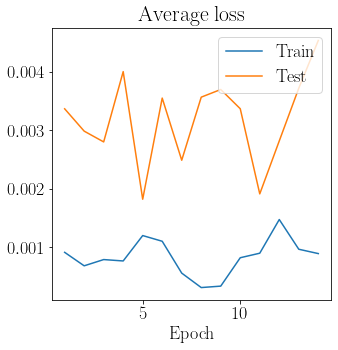

In [216]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_losses, test_losses=train(optimizer, 
      engine =RegressionEngine(model=model, optimizer = optimizer),
      early_stopping_iter = 100,
      epochs=100)

In [217]:
np.array(train_losses).shape, np.array(test_losses).shape

((14,), (14,))

In [218]:
# plt.plot(np.arange(1, train_losses.shape

In [219]:
def predict():
    outputs = []
    labels = []
    accuracies = []

    #evaluate
    with torch.no_grad():
        for data in test_loader:
            data_cp = copy.deepcopy(data)

            xtest = data_cp["x"]
            ytest = data_cp["y"]#y is Z values. I could add here my computed p-value for each theta,
            #and make a dataframe col1:theta, col2: Z, col3, phat, col4: computedp-value
            output = model(xtest)
            labels.append(ytest)
            outputs.append(output)

            y_predicted_cls = output.round()
            acc = y_predicted_cls.eq(ytest).sum() / float(ytest.shape[0])# number of correct predictions/sizeofytest
            #accuracies.append(acc.numpy())
            #print(f'accuracy: {acc.item():.4f}')

            del data_cp

    #     acc = y_predicted_cls.eq(ytest).sum() / float(ytest.shape[0])
    #     print(f'accuracy: {acc.item():.4f}')
            
    OUTPUTS = torch.cat(outputs).view(-1).numpy()

    LABELS = torch.cat(labels).view(-1).numpy()
    print('outputs of model: ', OUTPUTS)
    print('\nactual labels (targets Z): ', LABELS)
    return OUTPUTS.flatten(), LABELS.flatten()

In [220]:
OUTPUTS, LABELS = predict()

outputs of model:  [0.99262035 0.92160416 0.9969234  ... 0.9497656  0.98724824 0.96784693]

actual labels (targets Z):  [28.2491 28.3123 28.2231 ... 20.7069 24.4039 29.9623]


(array([1.8277e+04, 1.4950e+03, 1.8000e+02, 3.3000e+01, 6.0000e+00,
        3.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([ 20.0008  ,  37.75662 ,  55.51244 ,  73.268265,  91.02408 ,
        108.7799  , 126.53572 , 144.29155 , 162.04736 , 179.80319 ,
        197.559   ], dtype=float32),
 <BarContainer object of 10 artists>)

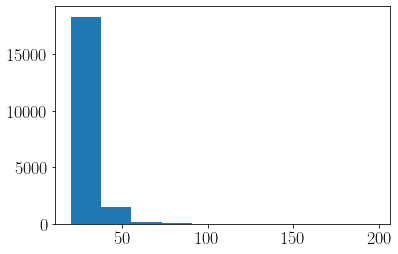

In [207]:
plt.hist(LABELS)

In [ ]:
def calc_phat_from_regressor(model, test_data):
    X_torch = torch.from_numpy(X).float()
    X_torch= Tensor(X_torch)
    model.eval()
    phat = model(X_torch)
    phat = phat.squeeze()
    phat=phat.detach().numpy().flatten()#detaches it from the computational history/prevent future computations from being tracked
    